In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt

# London Crime Clustering

The purpose of this notebook is to examine the case of clusters of certain types of crime in London and to also advance my understanding of hierarchical clustering.

The theory is that given that 'birds of a feather flock together' then if different types of crime were examined in London then clusters of certain types of crime would appear geographically concentrated. For example, if one locality has a high proportion of knife crime then it would be thought that the locality next door would also be likely to have a high proportion of crime as well. Thus, if we were to identify certain types of clusters, then localities close together would naturally be expected to belong to the same cluster.



# Hierarchical clustering

Hierarchical clustering is part of the unsupervised learning models of machine learning. This means that we don't have a defined target variable unlike in regression or classification. The point of this machine learning algorithm therefore is to identify distinct custers of objects that share similar characteristics. Other machine learning algorithms that fit in with part of this family include kmeans, DBscan. 

This specific algorithm comes in two forms: top-down or bottom up. The first, top-down, starts treats all points as part of a single cluster and then gradually breaks them up into seperate clusters (divissive) until they are all part of their own cluster. The second, bottom-up, starts from the basis that all points are part of their own cluster and then groups the two closest points together, iteratively, until they are all part of a single cluster (Agglomerative). This hierarchy of clusters can be can be represnted as a tree (or a dendrogram) as below, the leaves representing individual clusters and distance increasing as go up the clusters.

## Linkage

The formation of these groups depends on the choice of different linkage metrics:

### Wards

This approach of calculating similarity between the two clusters is the same as group average, excpet this calculates the sum of squares of the distances $P_i$ and $P_j$. Essentiallt this minimises the variance of the clusters being merged. Mathematically this can be written as:

sim($C_1$, $C_2$) = $\sum (dist(P_i, P_j))^2/|C_1|*|C_2|$

The benefits of this method is that it does well in seperating clusters if there is noise but it is biased towards circular groups of clusters.

### Complete/maximum 

This is the opposite to the minimum approach as the simialrity of the two clusters is equal to the maximum of the similarity between points within each of the clusters. This can be wriiten as:

Sim($C_1$, $C_2$) = Max Sim($P_i$, $P_j$) such that $P_i \in C_1$ & $P_j \in C_2$

This does well in seperating clusters if there is noise between them, but it is biased towards circular clusters and tends to break up large clusters.

### Average 

This linkage measure uses the average of the distances of all observations of the two sets. Mathematically this is represented as:

sim ($C_1$, $C_2$) = $\sum_{ij} (P_i, P_j)/|C_1|*|C_2|$

This does well in seperating clusters if tehre is noise between the clusters but is biased towards clusters that form blobs.

### Single/Min

This measures the similarity of two clusters as equal to the minimum of the similarity between the points closest to each other. Mathematically this is represented as:

Sim($C_1$, $C_2$) = Min Sim($P_i$, $P_j$) such that $P_i \in C_1$ & $P_j \in C_2$

The benefit of this measure is that it can deal with non-standard shapes of clusters, but cannot seperate clusters properly if there is noise.

## Affinity [2](https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d) [3](https://www.analyticsvidhya.com/blog/2020/02/4-types-of-distance-metrics-in-machine-learning/)

These will also depend on the choice of distance metric (affinity) used as well:

### Euclidean (l2)

This is the default distance metric used to measure the distance between clusters and is simply the straight line distance between two points. This is mathematically expressed as:

$d(x,y) = \sqrt{\sum_i (x_i - y_i)^2}$


### Manhattan (l1)

This distance is the sum of absolute difference between points across all the dimensions. This works as if there was grid like path between the points. This is mathematically expressed as:

$d(x,y) = \sum_{n=1} |x_i - y_i|$

This is also known as Taxicab Geometry and City Block Distance among others. This distance is often good for sparse features.

### Cosine

This distance metric measures the degree of angle between two vectores. This is used when the magnitude between points does not matter but the orientation does and is often used in natural language programming. This is measured as:

$\cos(\theta) = \frac{A \dot B}{||A||*||B||}$

### Precomputed

This is used if you already have a precomputed distance matrix for your observations.

The chosen metric aims to maximise the distance between samples in different classes and minimises the distance between each class [1](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

The benefits of hierarchical clustering, in comparison to other methods of clustering, is that it does not need the number of clusters to be specified. Furthermore, the algorithm is not that sensitive to the distance metric. This is especially useful when the underlying data has a hierarchical structure or that is what we expect from the data. However, this comes at the cost of lower efficiency due to a time complxity of O(n³) and space complexity of O(n²). Furthermore there is no natural performance metric for hierarchical clustering to tell which number of clusters best fits the data, unlike with kmeans or DBscan.



In [2]:
crime = pd.read_csv("https://data.london.gov.uk/download/recorded_crime_summary/644a9e0d-75a3-4c3a-91ad-03d2a7cb8f8e/MPS%20LSOA%20Level%20Crime%20%28most%20recent%2024%20months%29.csv")

In [3]:
crime

,LSOA Code,Borough,Major Category,Minor Category,201901,201902,201903,201904,201905,201906,...,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
0,E01000006,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,E01000007,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,E01000009,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E01000010,Barking and Dagenham,Arson and Criminal Damage,Arson,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,E01000013,Barking and Dagenham,Arson and Criminal Damage,Arson,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103931,E01033604,Westminster,Violence Against the Person,Violence without Injury,2,5,3,7,5,7,...,7,3,4,7,4,5,4,12,4,8
103932,E01033605,Westminster,Violence Against the Person,Violence without Injury,2,3,5,7,2,1,...,1,5,4,4,5,4,4,5,2,4
103933,E01033606,Westminster,Violence Against the Person,Violence without Injury,1,0,1,1,1,3,...,2,1,1,1,0,0,4,2,0,0
103934,E01033607,Westminster,Violence Against the Person,Violence without Injury,2,4,1,1,1,1,...,0,1,3,1,2,3,0,1,2,2


In [4]:
major_cats = crime["Major Category"].unique()
minor_cats = crime["Minor Category"].unique()

print(major_cats)
print(minor_cats)

['Arson and Criminal Damage' 'Burglary' 'Drug Offences'
 'Miscellaneous Crimes Against Society' 'Possession of Weapons'
 'Public Order Offences' 'Robbery' 'Theft' 'Vehicle Offences'
 'Violence Against the Person']
['Arson' 'Criminal Damage' 'Burglary - Business and Community'
 'Burglary - Residential' 'Drug Trafficking' 'Possession of Drugs'
 'Bail Offences' 'Bigamy' 'Dangerous Driving'
 'Disclosure, Obstruction, False or Misleading State'
 'Exploitation of Prostitution'
 'Fraud or Forgery Associated with Driver Records'
 'Going Equipped for Stealing' 'Handling Stolen Goods'
 'Making, Supplying or Possessing Articles for use i'
 'Obscene Publications' 'Other Forgery' 'Other Notifiable Offences'
 'Perjury' 'Perverting Course of Justice' 'Possession of False Documents'
 'Profitting From or Concealing Proceeds of Crime'
 'Threat or Possession With Intent to Commit Crimina' 'Wildlife Crime'
 'Other Firearm Offences' 'Possession of Article with Blade or Point'
 'Possession of Firearm with I

In [5]:
cols_to_sum_19 = [col for col in crime.columns if "2019" in str(col)]
cols_to_sum_20 = [col for col in crime.columns if "2020" in str(col)]

crime["2019"] = crime[cols_to_sum_19].sum(axis = 1)
crime["2020"] = crime[cols_to_sum_20].sum(axis = 1)

In [6]:
crime = crime[["LSOA Code", "Major Category", "2019", "2020"]]
crime

,LSOA Code,Major Category,2019,2020
0,E01000006,Arson and Criminal Damage,1,2
1,E01000007,Arson and Criminal Damage,0,1
2,E01000009,Arson and Criminal Damage,2,0
3,E01000010,Arson and Criminal Damage,4,0
4,E01000013,Arson and Criminal Damage,0,1
...,...,...,...,...
103931,E01033604,Violence Against the Person,61,75
103932,E01033605,Violence Against the Person,49,44
103933,E01033606,Violence Against the Person,13,14
103934,E01033607,Violence Against the Person,20,16


In [7]:
crime[crime["LSOA Code"] == "E01000006"]

,LSOA Code,Major Category,2019,2020
0,E01000006,Arson and Criminal Damage,1,2
64,E01000006,Arson and Criminal Damage,6,4
254,E01000006,Burglary,13,5
364,E01000006,Drug Offences,0,1
445,E01000006,Drug Offences,6,24
653,E01000006,Miscellaneous Crimes Against Society,3,1
771,E01000006,Miscellaneous Crimes Against Society,1,0
1111,E01000006,Public Order Offences,2,0
1204,E01000006,Public Order Offences,3,0
1314,E01000006,Public Order Offences,0,3


In [8]:
crime_2019 = crime.drop(columns = ["2020"]).copy()

In [9]:
crime_2019

,LSOA Code,Major Category,2019
0,E01000006,Arson and Criminal Damage,1
1,E01000007,Arson and Criminal Damage,0
2,E01000009,Arson and Criminal Damage,2
3,E01000010,Arson and Criminal Damage,4
4,E01000013,Arson and Criminal Damage,0
...,...,...,...
103931,E01033604,Violence Against the Person,61
103932,E01033605,Violence Against the Person,49
103933,E01033606,Violence Against the Person,13
103934,E01033607,Violence Against the Person,20


In [10]:
crime_2019[(crime_2019["LSOA Code"] == "E01000006") & (crime_2019["Major Category"] == "Arson and Criminal Damage" )]

,LSOA Code,Major Category,2019
0,E01000006,Arson and Criminal Damage,1
64,E01000006,Arson and Criminal Damage,6


In [11]:
crime_2019 = crime_2019.pivot_table(index= 'LSOA Code', columns = 'Major Category', 
                                    values = "2019", aggfunc = np.sum,
                                    fill_value = 0).reset_index()
crime_2019.rename_axis(None,axis=1, inplace=True)

In [12]:
cols_to_sum = [col for col in crime_2019.columns if "LSOA" not in col]

crime_2019["Total_crime"] = crime_2019[cols_to_sum].sum(axis=1)

In [13]:
for col in cols_to_sum:
    crime_2019[col] = crime_2019[col]/crime_2019["Total_crime"]

In [14]:
crime_2019

,LSOA Code,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Theft,Vehicle Offences,Violence Against the Person,Total_crime
0,E01000006,0.064220,0.119266,0.055046,0.036697,0.000000,0.045872,0.100917,0.064220,0.128440,0.385321,109
1,E01000007,0.040462,0.038536,0.129094,0.011561,0.009634,0.055877,0.111753,0.289017,0.061657,0.252408,519
2,E01000008,0.068182,0.077273,0.072727,0.013636,0.000000,0.063636,0.031818,0.250000,0.186364,0.236364,220
3,E01000009,0.051852,0.051852,0.088889,0.007407,0.003704,0.059259,0.114815,0.244444,0.074074,0.303704,270
4,E01000010,0.040802,0.035270,0.075380,0.008299,0.012448,0.051176,0.064315,0.456432,0.057400,0.198479,1446
...,...,...,...,...,...,...,...,...,...,...,...,...
4824,E01033742,0.102041,0.061224,0.040816,0.000000,0.000000,0.020408,0.020408,0.122449,0.367347,0.265306,49
4825,E01033743,0.045198,0.022599,0.014124,0.005650,0.002825,0.036723,0.011299,0.587571,0.087571,0.186441,354
4826,E01033744,0.107143,0.064286,0.021429,0.000000,0.000000,0.071429,0.014286,0.071429,0.221429,0.428571,140
4827,E01033745,0.143836,0.095890,0.047945,0.013699,0.006849,0.034247,0.027397,0.116438,0.205479,0.308219,146


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

crime_2019["Total_crime"] = scaler.fit_transform(crime_2019["Total_crime"].values.reshape(-1,1))

In [16]:
crime_2019

,LSOA Code,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Theft,Vehicle Offences,Violence Against the Person,Total_crime
0,E01000006,0.064220,0.119266,0.055046,0.036697,0.000000,0.045872,0.100917,0.064220,0.128440,0.385321,0.009977
1,E01000007,0.040462,0.038536,0.129094,0.011561,0.009634,0.055877,0.111753,0.289017,0.061657,0.252408,0.053492
2,E01000008,0.068182,0.077273,0.072727,0.013636,0.000000,0.063636,0.031818,0.250000,0.186364,0.236364,0.021758
3,E01000009,0.051852,0.051852,0.088889,0.007407,0.003704,0.059259,0.114815,0.244444,0.074074,0.303704,0.027064
4,E01000010,0.040802,0.035270,0.075380,0.008299,0.012448,0.051176,0.064315,0.456432,0.057400,0.198479,0.151879
...,...,...,...,...,...,...,...,...,...,...,...,...
4824,E01033742,0.102041,0.061224,0.040816,0.000000,0.000000,0.020408,0.020408,0.122449,0.367347,0.265306,0.003609
4825,E01033743,0.045198,0.022599,0.014124,0.005650,0.002825,0.036723,0.011299,0.587571,0.087571,0.186441,0.035980
4826,E01033744,0.107143,0.064286,0.021429,0.000000,0.000000,0.071429,0.014286,0.071429,0.221429,0.428571,0.013267
4827,E01033745,0.143836,0.095890,0.047945,0.013699,0.006849,0.034247,0.027397,0.116438,0.205479,0.308219,0.013904


In [17]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering



In [18]:
UK_LSOA = gpd.read_file("https://opendata.arcgis.com/datasets/1f23484eafea45f98485ef816e4fee2d_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D")

UK_LSOA = UK_LSOA[["LSOA11CD", "geometry"]]

In [19]:
London_crime = UK_LSOA.merge(crime_2019, left_on = "LSOA11CD", right_on = "LSOA Code", how = "right")

<AxesSubplot:>

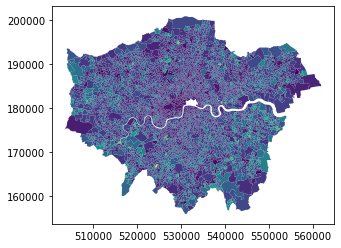

In [20]:
London_crime.plot(column = "Arson and Criminal Damage")

<AxesSubplot:>

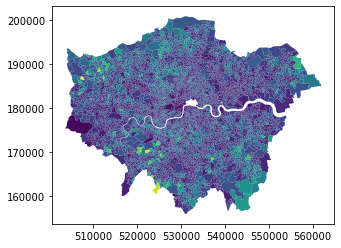

In [21]:
London_crime.plot(column = "Burglary")

['Arson and Criminal Damage', 'Burglary', 'Drug Offences', 'Miscellaneous Crimes Against Society', 'Possession of Weapons', 'Public Order Offences', 'Robbery', 'Theft', 'Vehicle Offences', 'Violence Against the Person']


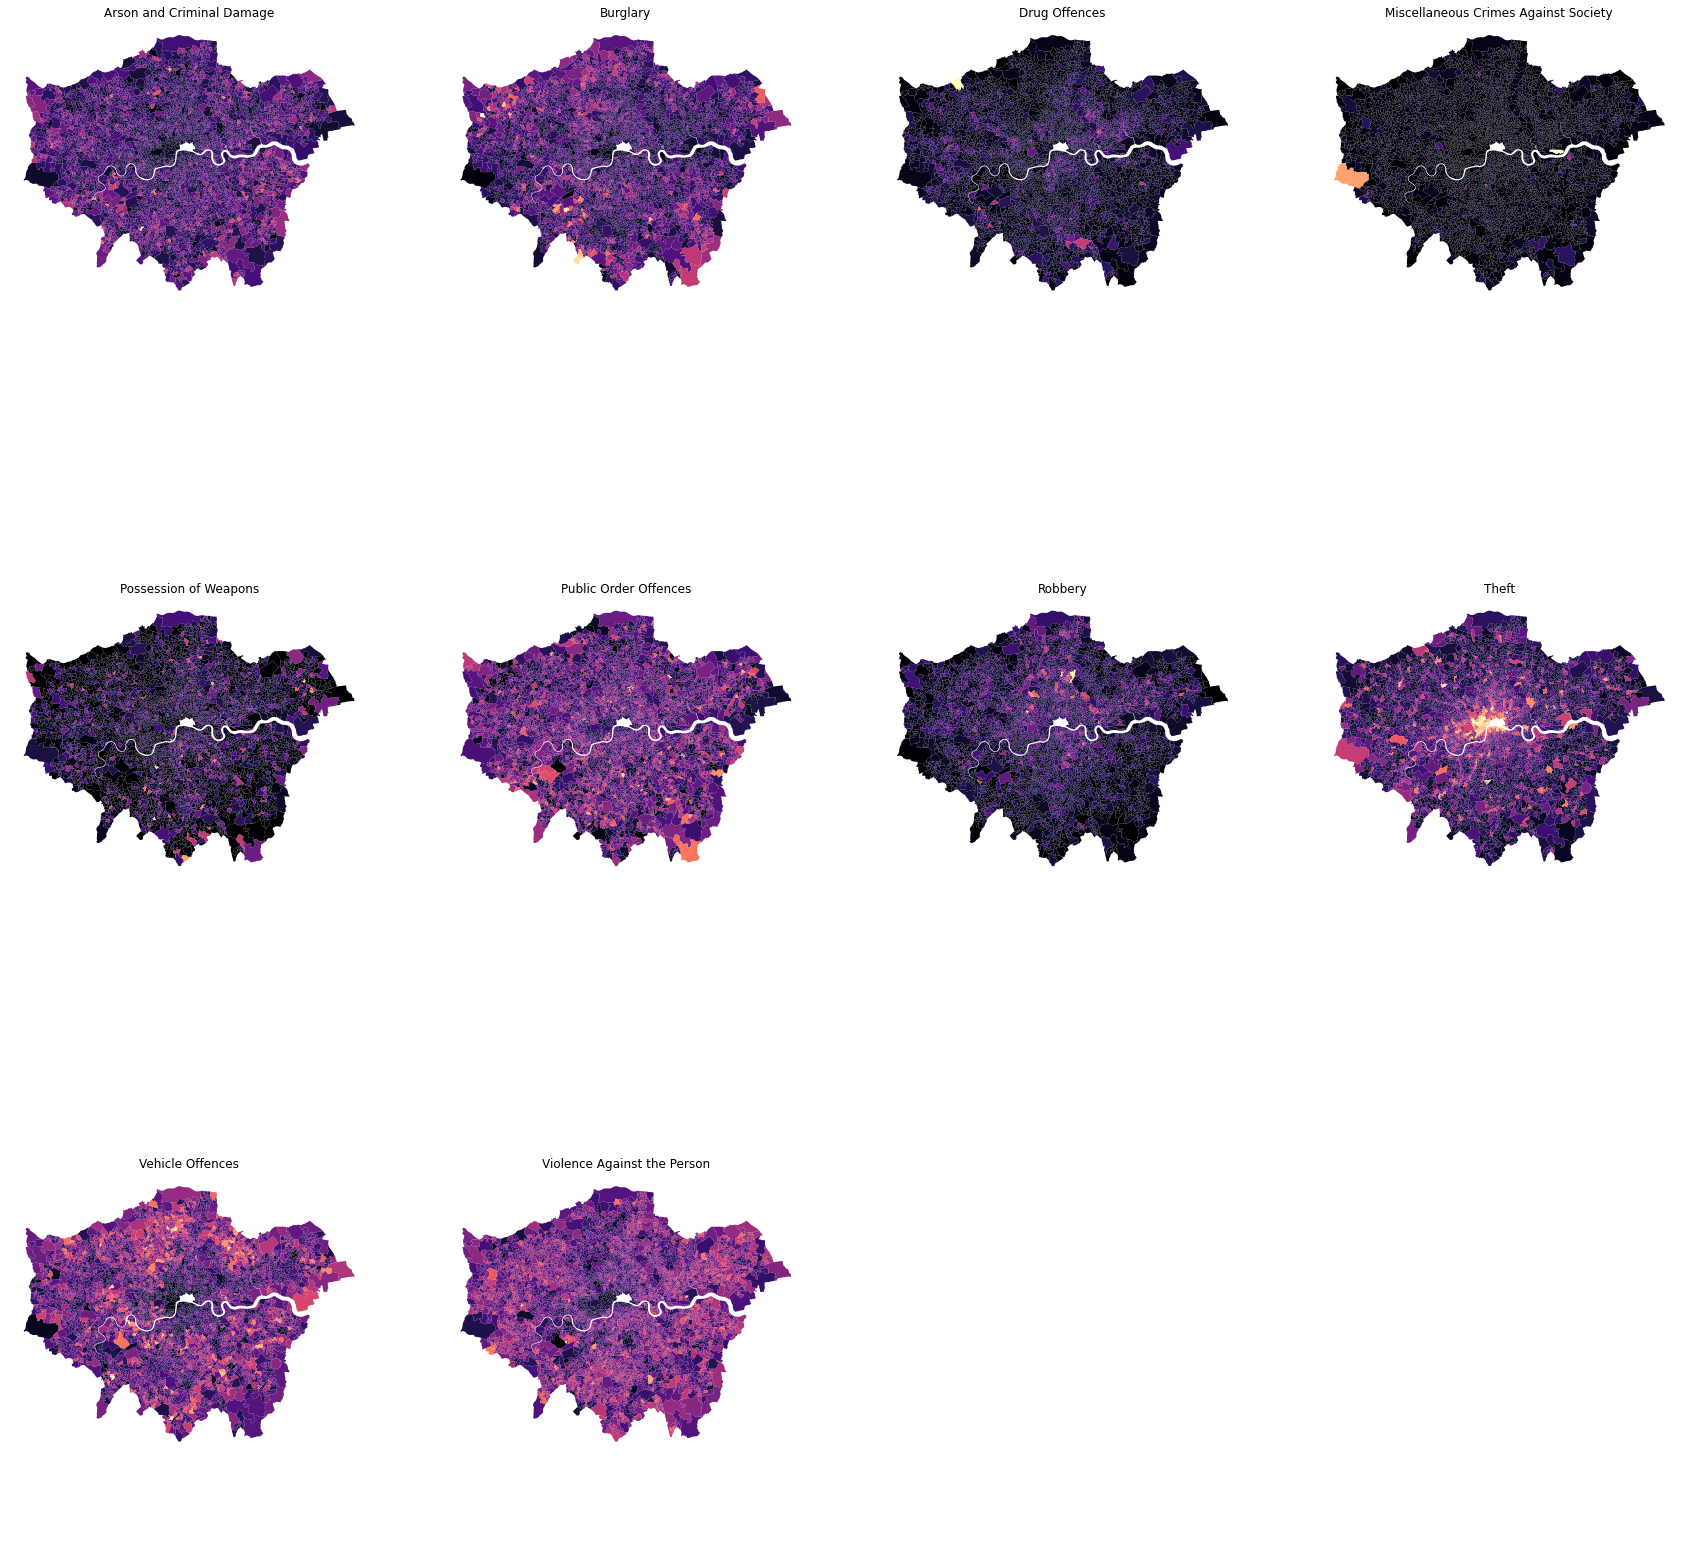

In [22]:
London_crime.columns
not_plot = ["LSOA11CD", "geometry", "LSOA Code", "Total_crime"]
to_plot = [col for col in London_crime.columns if col not in not_plot]

print(to_plot)

fig, axis = plt.subplots(3,4, figsize = (30,30))
axis = axis.flatten()

for i, col in enumerate(to_plot):
    ax = axis[i]
    London_crime.plot(column = col, ax=ax, cmap = "magma")
    ax.set_axis_off()
    ax.set_title(col)

axis[10].set_axis_off()
axis[11].set_axis_off()
plt.show()

In [23]:
from libpysal.weights import Queen

In [24]:
w = Queen.from_dataframe(London_crime)

In [25]:
from esda.moran import Moran

mi_results = [Moran(London_crime[col], w) for col in to_plot]

table = pd.DataFrame([(to_plot, res.I, res.p_sim) \
                          for to_plot,res \
                          in zip(to_plot, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')

table.sort_values(by= ["Moran's I"], ascending=False)

,Moran's I,P-value
Variable,,
Theft,0.361071,0.001
Vehicle Offences,0.360416,0.001
Robbery,0.335505,0.001
Drug Offences,0.321585,0.001
Violence Against the Person,0.321576,0.001
Burglary,0.280848,0.001
Arson and Criminal Damage,0.156422,0.001
Public Order Offences,0.099505,0.001
Possession of Weapons,0.068194,0.001


In [26]:
crime_clus = London_crime[to_plot]

In [27]:
model = AgglomerativeClustering(linkage="ward", distance_threshold = 4, n_clusters=None)

model.fit(crime_clus)

AgglomerativeClustering(distance_threshold=4, n_clusters=None)

In [28]:
London_crime["Aggl_clus"] = model.labels_

<AxesSubplot:>

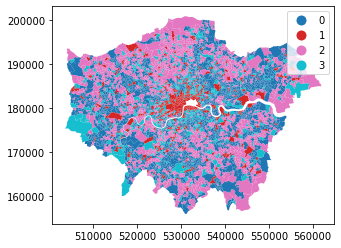

In [29]:
London_crime.plot(column = "Aggl_clus", categorical = True, legend=True)

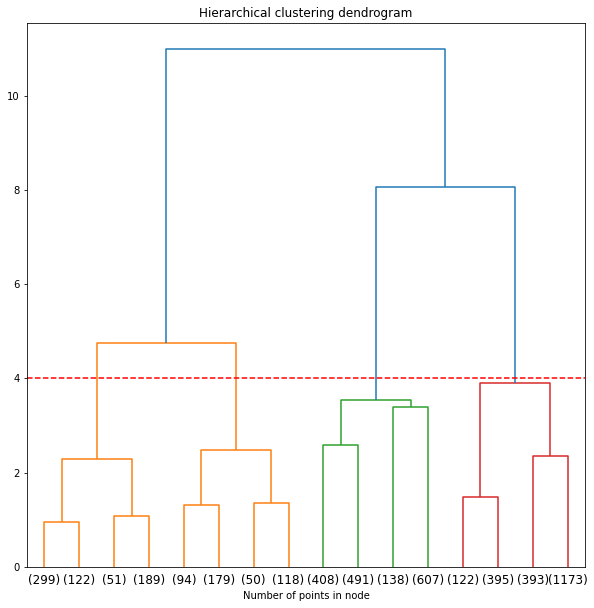

In [30]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.axhline(y = 4, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

In [31]:
agglom_sizes = London_crime.groupby("Aggl_clus").size()
agglom_sizes

Aggl_clus
0    2083
1     441
2    1644
3     661
dtype: int64

In [32]:
agglom_means =London_crime.groupby("Aggl_clus")[to_plot].mean()
agglom_means.T.round(3)

Aggl_clus,0,1,2,3
Arson and Criminal Damage,0.087,0.042,0.072,0.062
Burglary,0.097,0.074,0.161,0.103
Drug Offences,0.065,0.039,0.035,0.053
Miscellaneous Crimes Against Society,0.015,0.008,0.012,0.011
Possession of Weapons,0.010,0.006,0.006,0.008
Public Order Offences,0.064,0.056,0.046,0.061
Robbery,0.039,0.046,0.032,0.047
Theft,0.136,0.465,0.107,0.279
Vehicle Offences,0.145,0.089,0.284,0.158
Violence Against the Person,0.343,0.174,0.245,0.216


In [33]:
agglom_means_T = agglom_means.T.round(3).copy()
agglom_means_T.reset_index(inplace=True)
agglom_means_T = pd.DataFrame(agglom_means_T)

In [34]:
#fig, ax = plt.subplots(3,1, figsize = (30,15))
#for col in agglom_means_T:
#    agglom_means_T.plot.barh(x = col, y="Aggl_clus")

## Spatially constrained hierarchical clustering

In [35]:
model = AgglomerativeClustering(linkage="ward", 
                                connectivity = w.sparse,
                                distance_threshold = 2.5, 
                                n_clusters=None)

model.fit(crime_clus)

AgglomerativeClustering(connectivity=<4829x4829 sparse matrix of type '<class 'numpy.float64'>'
	with 28494 stored elements in Compressed Sparse Row format>,
                        distance_threshold=2.5, n_clusters=None)

<AxesSubplot:>

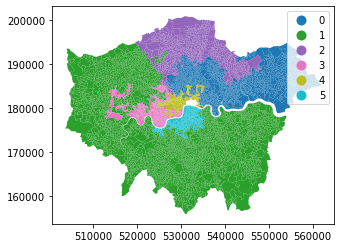

In [36]:
London_crime["Aggl_clus_spa"] = model.labels_
London_crime.plot(column = "Aggl_clus_spa", categorical = True, legend=True)

In [37]:
agglom_means =London_crime.groupby("Aggl_clus_spa")[to_plot].mean()
agglom_means.T.round(3)

Aggl_clus_spa,0,1,2,3,4,5
Arson and Criminal Damage,0.072,0.082,0.071,0.064,0.035,0.063
Burglary,0.103,0.125,0.136,0.107,0.089,0.099
Drug Offences,0.063,0.047,0.033,0.053,0.039,0.072
Miscellaneous Crimes Against Society,0.014,0.013,0.013,0.009,0.006,0.013
Possession of Weapons,0.009,0.007,0.007,0.007,0.005,0.011
Public Order Offences,0.058,0.058,0.048,0.061,0.047,0.059
Robbery,0.049,0.030,0.044,0.044,0.052,0.047
Theft,0.181,0.148,0.126,0.242,0.501,0.254
Vehicle Offences,0.161,0.200,0.270,0.178,0.084,0.113
Violence Against the Person,0.290,0.290,0.253,0.236,0.141,0.269


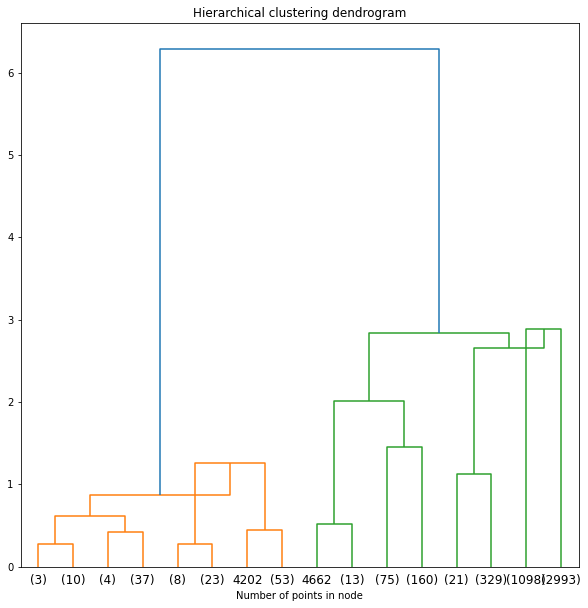

In [38]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
ax.set_xlabel("Number of points in node")
plt.show()